<a href="https://colab.research.google.com/github/montimaj/Deep-Learning-SE-6213/blob/master/HW5/Groundwater_Withdrawals_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [117]:
%cd 'drive/My Drive/SysEng 6213 Fall 2020 Sayantan Majumdar /HW5/Data'
!ls

GW_DF_KS_AZ.csv


In [118]:
import pandas as pd

In [119]:
gw_df = pd.read_csv('GW_DF_KS_AZ.csv')
print('Number of data entries (including no data):', gw_df.size)
features = gw_df.columns.values
print('Data dimension:', gw_df.shape)
print('Number of Samples/Rows:', gw_df.shape[0])
print('Number of Features:', gw_df.shape[1])
print('Feature names:', features)
print('Target variable to be predicted:', features[2])
print('\nFeature\tDescription\t\t\t\t\t\t\t\t\t Datatype')
print(features[0], '\tAgriculture density (unitless, normalized between 0 and 1 (inclusive))\t\t', gw_df.AGRI.dtype)
print(features[1], '\tCrop coefficient (unitless)\t\t\t\t\t\t\t', gw_df.Crop.dtype)
print(features[2], '\tAnnual groundwater withdrawals (mm)\t\t\t\t\t\t', gw_df.GW.dtype)
print(features[3], '\tTotal precipitation for the growing season between April and October (mm)\t', gw_df.P.dtype)
print(features[4], '\tSSEBop ET for the growing season between April and October (mm)\t\t\t', gw_df.SSEBop.dtype)
print(features[5], '\tSurface water density (unitless, normalized between 0 and 1 (inclusive))\t', gw_df.SW.dtype)
print(features[6], '\tUrban density (unitless, normalized between 0 and 1 (inclusive))\t\t', gw_df.URBAN.dtype)
print(features[7], '\tYear (2002-2019)\t\t\t\t\t\t\t\t', gw_df.YEAR.dtype)

Number of data entries (including no data): 3088560
Data dimension: (386070, 8)
Number of Samples/Rows: 386070
Number of Features: 8
Feature names: ['AGRI' 'Crop' 'GW' 'P' 'SSEBop' 'SW' 'URBAN' 'YEAR']
Target variable to be predicted: GW

Feature	Description									 Datatype
AGRI 	Agriculture density (unitless, normalized between 0 and 1 (inclusive))		 float64
Crop 	Crop coefficient (unitless)							 float64
GW 	Annual groundwater withdrawals (mm)						 float64
P 	Total precipitation for the growing season between April and October (mm)	 float64
SSEBop 	SSEBop ET for the growing season between April and October (mm)			 float64
SW 	Surface water density (unitless, normalized between 0 and 1 (inclusive))	 float64
URBAN 	Urban density (unitless, normalized between 0 and 1 (inclusive))		 float64
YEAR 	Year (2002-2019)								 int64


In [120]:
na_col = gw_df.isna().sum()
print('Number of NA/Missing values in each column')
print(na_col)
print('\nTotal number of NA/Missing values:', na_col.sum())
num_samples_old = gw_df.shape[0]
gw_df_cleaned = gw_df.dropna()
num_samples_new = gw_df_cleaned.shape[0]
print('\nNumber of rows having missing values removed:', num_samples_old - num_samples_new)

Number of NA/Missing values in each column
AGRI      205292
Crop      207417
GW        205299
P         208284
SSEBop    205292
SW        205292
URBAN     205292
YEAR           0
dtype: int64

Total number of NA/Missing values: 1442168

Number of rows having missing values removed: 208496


**1. Unsupervised dimensionality reduction with principal component analysis (PCA)**

In [121]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [123]:
np.random.seed(0)  # This is required for reproducibility

In [124]:
# Using NA removed data frame, NA values represent pixels outside the study area and therefore, need to be removed
X, y = gw_df_cleaned.drop(columns='GW'), gw_df_cleaned['GW'].to_numpy().reshape(-1, 1) # GW is the target variable
# Data scaling, transformed values will lie in the [0, 1] interval
X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2)

Text(278.1423913043478, 0.5, 'GW')

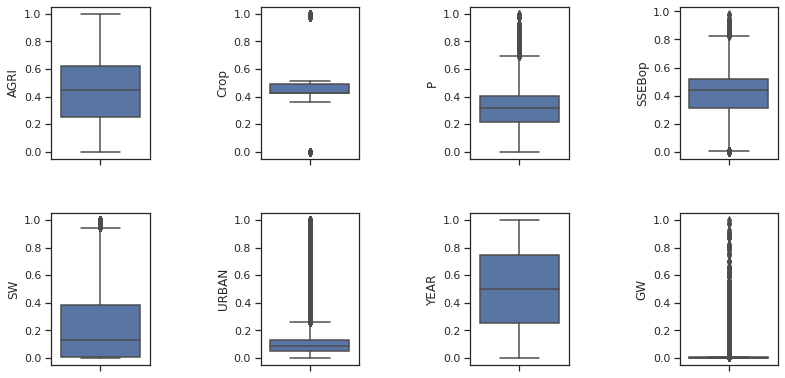

In [125]:
scaled_df = pd.DataFrame(data=X_train)  # creating X_train dataframe for seaborn boxplots
features = X.columns.values
scaled_df.columns = features
# Data distribution check
fig, axes = plt.subplots(ncols=4, nrows=2)
fig.tight_layout()
axes = axes.ravel()
fig.set_size_inches(12, 6)
for idx, axis in enumerate(axes):
  if idx < len(features):
    sns.boxplot(x=None, y=scaled_df[features[idx]], ax=axis)
sns.boxplot(x=None, y=y_scaled, ax=axes[-1])
axes[-1].set_ylabel('GW')

None of the features along with the target variable have normally distributed data. However, AGRI is somewhat close to exhibiting normal distribution

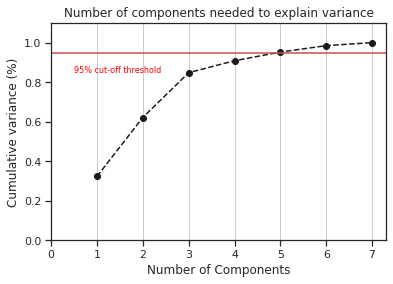

In [126]:
pca = PCA().fit(X_train)
fig, ax = plt.subplots()
features = X.columns.values
num_features = len(features)
x_values = np.arange(1, num_features + 1, step=1)
y_values = np.cumsum(pca.explained_variance_ratio_)
plt.ylim(0, 1.1)
plt.plot(x_values, y_values, marker='o', linestyle='--', color='k')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, num_features + 1, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('Number of components needed to explain variance')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=8)
ax.grid(axis='x')
plt.show()


We see that 5 components are sufficient to explain 95% variance. So we can select 5 principal components as follows.

Original dimension: (142059, 7) New dimension: (142059, 5)


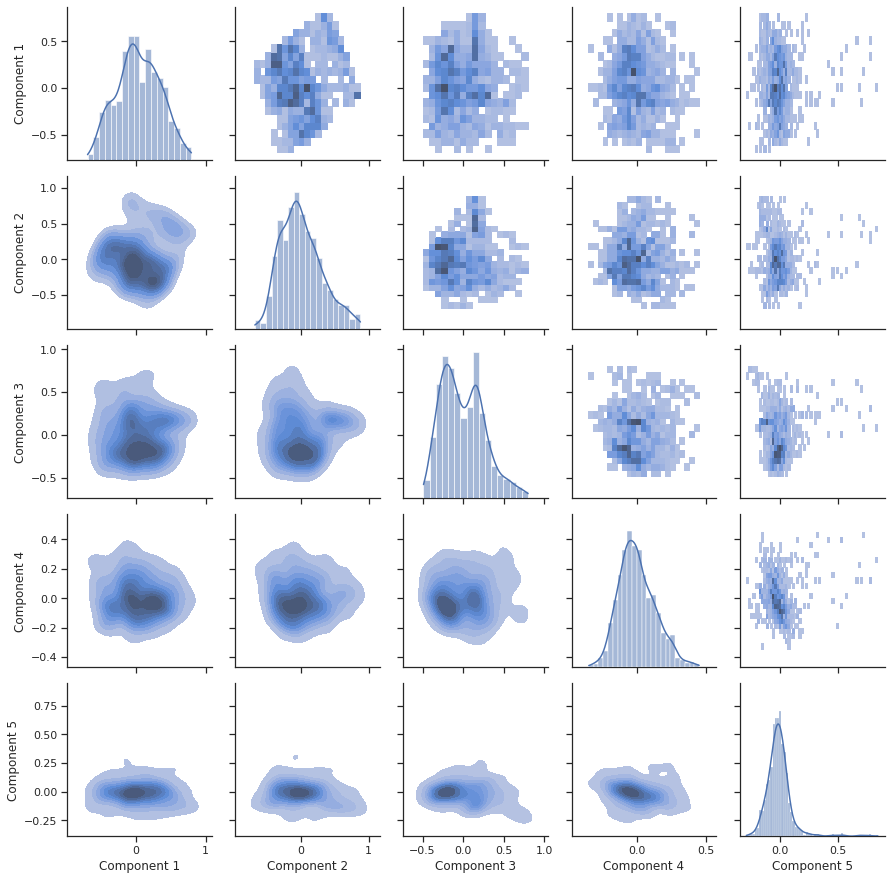

In [127]:
sns.set_theme(style="ticks")

# create scikit-learn decomposition PCA object with 5
pca = PCA(n_components=5)
# fit and transform scaled data, here scikit-learn automatically uses the randomized PCA as 
# the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
# Here we see that the data dimensionality has been reduced to 177574 X 5 from 177574 X 8.
print('Original dimension:', X_train.shape, 'New dimension:', X_train_pca.shape)

# Convert to dataframe and add column names to use seaborn plot
pca_df = pd.DataFrame(data=X_train_pca)
pca_df.columns = ['Component ' + str(comp + 1) for comp in range(0, 5)]
# pairwise scatter plots and corresponding histograms of the 5 components taking 1000 random samples
g = sns.PairGrid(pca_df.sample(1000))
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)



The contours represent kernel density estimates wherein high to low density is represented in blue to light blue shades. As expected, the variance reduces from component 1 to 5.

**N.B:** Taking larger sample sizes will increase the computation time.




**2. Supervised dimensionality reduction with linear discriminant analysis**

In [128]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

Since this algorithm only works for classification problems, we need to categorize GW into Low, Medium, High categories depending on user-defined thresholds. Here, I classifiy as follows

| GW Interval | Category |
|:-----------:|:--------:|
|   [0, 50)   |    0 (Low)   |
|  [50, 100]  |  1 (Medium)  |
|     >100    |   2 (High)   |

In [129]:
def categorize_data(arr):
  """
  Categorize data based on the above table
  """

  arr[arr < 50] = 0
  arr[np.logical_and(arr >= 50, arr <= 100)] = 1
  arr[arr > 100] = 2
  return arr.astype(np.int)

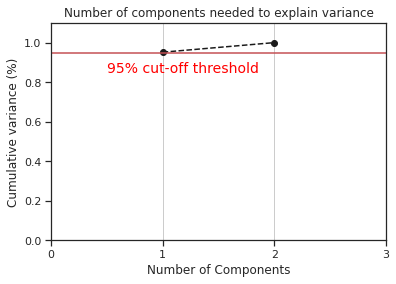

In [130]:
y_train_orig_scale = y_scaler.inverse_transform(y_train)
y_test_orig_scale = y_scaler.inverse_transform(y_test)
y_train_categorical = categorize_data(y_train_orig_scale.copy()).T.ravel()
y_test_categorical = categorize_data(y_test_orig_scale.copy()).T.ravel()


lda = LDA(solver='eigen').fit(X_train, y_train_categorical)  # We use eigen value decomposition because we only have 7 features
fig, ax = plt.subplots()
num_components = min(2, num_features)  # by default, n_components = min(n_features, n_classes - 1)
x_values = np.arange(1, num_components + 1)
y_values = np.cumsum(lda.explained_variance_ratio_)
plt.ylim(0, 1.1)
plt.plot(x_values, y_values, marker='o', linestyle='--', color='k')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, num_components + 2, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('Number of components needed to explain variance')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=14)
ax.grid(axis='x')
plt.show()

Since there are only 2 components (maximum) with only 3 classes so dimensionality reduction is not necessary. This is because we are forcefully transforming a regression problem into a classification problem. However, for performing dimensionality reduction, we select only one component as follows.



Using 2 components: Original dimension: (142059, 7) New dimension: (142059, 2)
Using 1 component: Original dimension: (142059, 7) New dimension: (142059, 1)


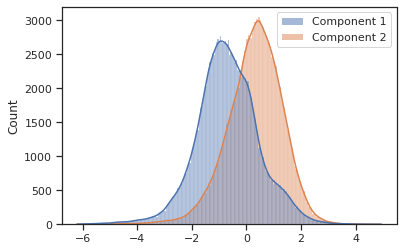

In [131]:
lda = LDA(solver='eigen', n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train_categorical)  # Fitting and transforming
X_test_lda = lda.transform(X_test)

# Here we see that the data dimensionality has been reduced to 177574 X 7 from 177574 X 2.
print('Using 2 components: Original dimension:', X_train.shape, 'New dimension:', X_train_lda.shape)

# Convert to dataframe and add column names to use seaborn plot
lda_df = pd.DataFrame(data=X_train_lda)
lda_df.columns = ['Component 1', 'Component 2']
# pairwise scatter plots and corresponding histograms of the 5 components taking 1000 random samples
sns.histplot(lda_df, kde=True)

lda = LDA(solver='eigen', n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train_categorical)  # Fitting and transforming
X_test_lda = lda.transform(X_test)

# Here we see that the data dimensionality has been reduced to 177574 X 7 from 177574 X 1.
print('Using 1 component: Original dimension:', X_train.shape, 'New dimension:', X_train_lda.shape)



**3.** **Non-linear dimensionality reduction with kernel principal component analysis (KPCA)**

In [132]:
from sklearn.decomposition import KernelPCA

In [133]:
# Using NA removed data frame, NA values represent pixels outside the study area and therefore, need to be removed
X, y = gw_df_cleaned.drop(columns='GW'), gw_df_cleaned['GW'].to_numpy().reshape(-1, 1) # GW is the target variable
# KPCA crashes in normal Google Colab with large samples, so smaller sample size is required
X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.99)
print(X_train.shape)

(1775, 7)


In [134]:
def plot_kpca(kpca, max_lambdas=50):
  """
  Plot KPCA eigenvalues
  :param max_lambdas: Maximum number of components in the x_axis
  """

  fig, ax = plt.subplots()
  fig.set_size_inches(12, 6)
  lambdas = kpca.lambdas_
  n_lambdas = len(lambdas)
  if n_lambdas > max_lambdas:
    lambdas = lambdas[:max_lambdas]
    n_lambdas = max_lambdas
  x_values = np.arange(1, n_lambdas + 1, step=1)
  plt.plot(x_values, np.log(lambdas), marker='o', linestyle='--', color='k')
  plt.ylim(0, np.log(max(lambdas)) + 1)
  plt.xlabel('Number of Components')
  if n_lambdas <= 20:
    plt.xticks(np.arange(0, n_lambdas + 1, step=1))
  plt.ylabel('Eigenvalue (Log Scale)')
  plt.title('Number of components vs Eigenvalues')
  ax.grid(axis='x')
  plt.show()

**Linear Kernel**

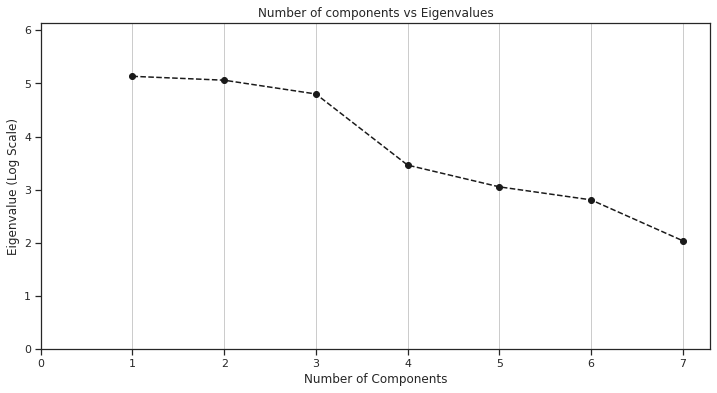

In [135]:
kpca_linear = KernelPCA(kernel="linear").fit(X_train)  # gamma is ignored, all components are used for obtaining the plot
plot_kpca(kpca_linear)



The linear KPCA shows that 5 components are sufficient

**Polynomial Kernel**

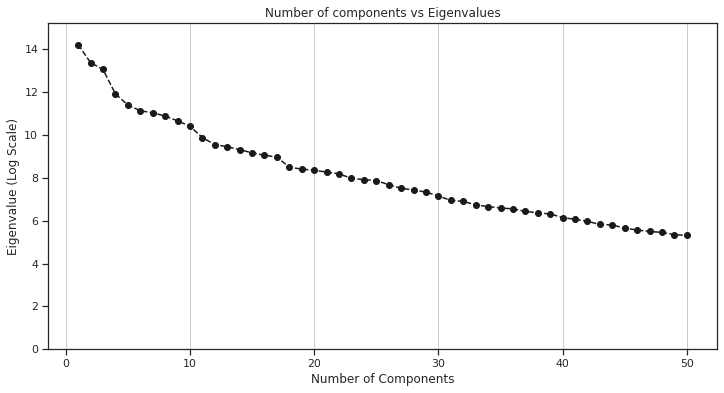

In [138]:
kpca_poly = KernelPCA(kernel='poly', gamma=10).fit(X_train)  # default polynomial degree is 3.
plot_kpca(kpca_poly)

The polynomial KPCA also shows that 5 components are sufficient

**RBF Kernel**

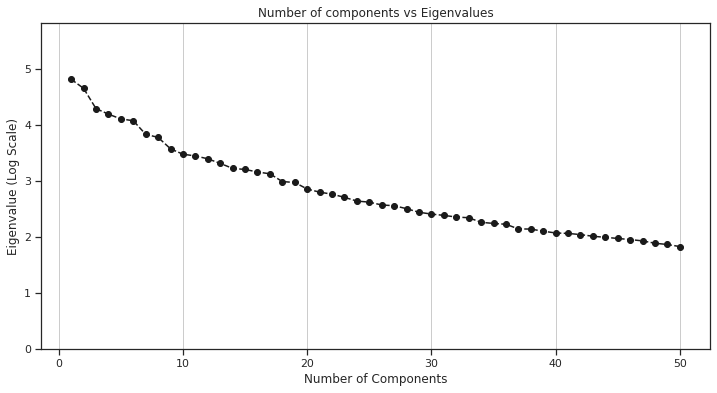

In [137]:
kpca_rbf = KernelPCA(kernel='rbf', gamma=10).fit(X_train)
plot_kpca(kpca_rbf)

**Sigmoid Kernel**

In [ ]:
# kpca_sigmoid = KernelPCA(kernel='sigmoid').fit(X_train)  # Doesn't work due to too many negative eigen values

**Cosine Kernel**

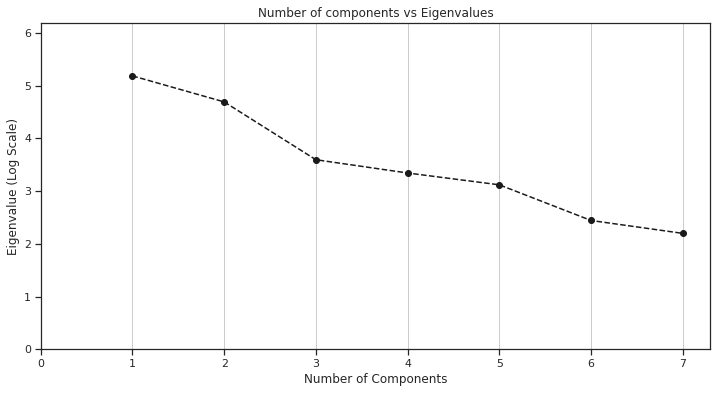

In [141]:

kpca_cosine = KernelPCA(kernel='cosine').fit(X_train)
plot_kpca(kpca_cosine)

Since the data exhibits polynomial non-linearity (as seen from the large eigen values), we'll use the polynomial kernel with 5 components as follows. 

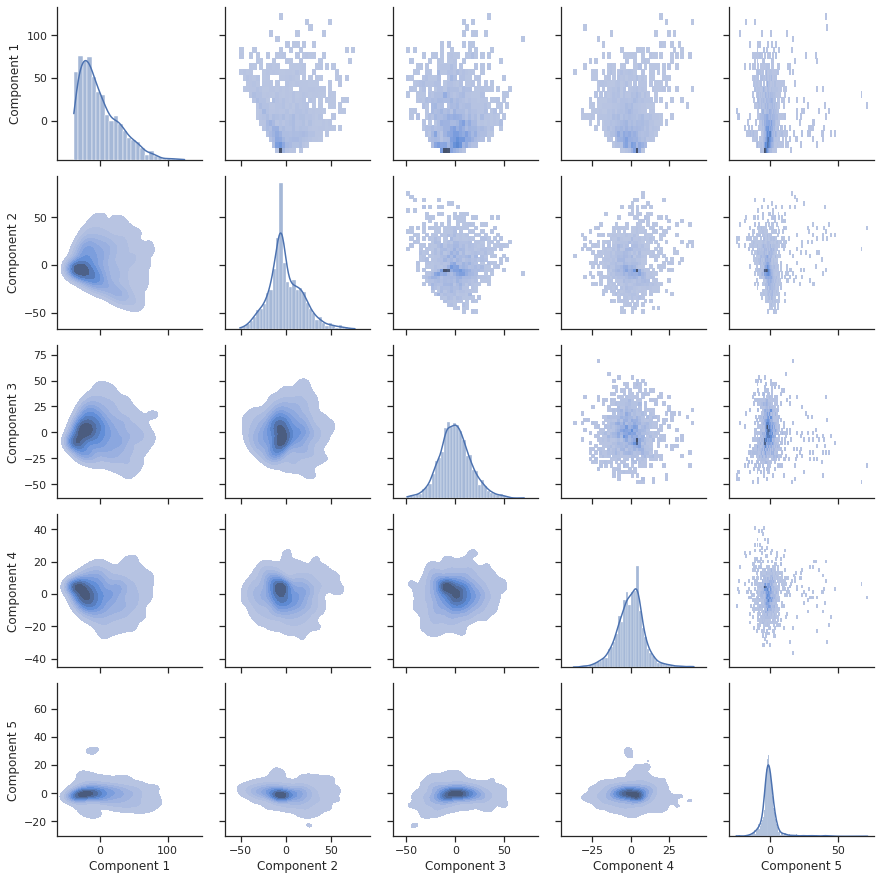

In [142]:
kpca_poly = KernelPCA(kernel='poly', gamma=10, n_components=5)
X_train_kpca_poly = kpca_poly.fit_transform(X_train)
X_test_kpca_poly = kpca_poly.transform(X_test)

# Convert to dataframe and add column names to use seaborn plot
kpca_df = pd.DataFrame(data=X_train_kpca_poly)
kpca_df.columns = ['Component ' + str(comp + 1) for comp in range(0, 5)]
# pairwise scatter plots and corresponding histograms of the 5 components taking 1000 random samples
g = sns.PairGrid(kpca_df)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

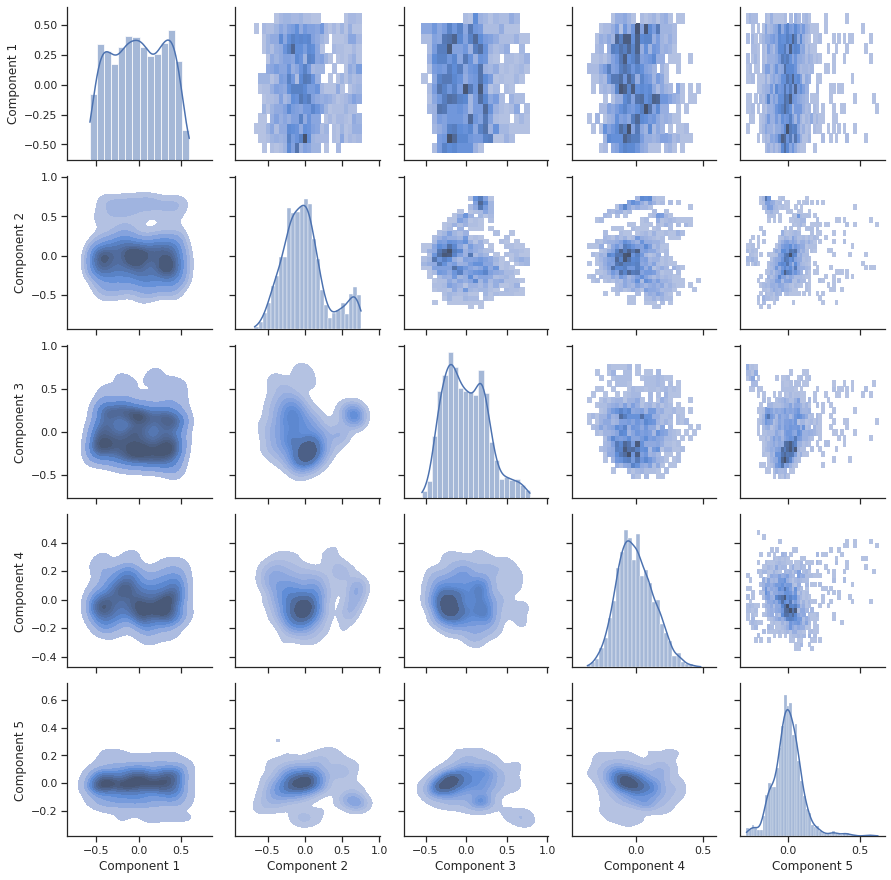

In [143]:
kpca_linear = KernelPCA(kernel='linear', n_components=5)
X_train_kpca_linear = kpca_linear.fit_transform(X_train)
X_test_kpca_linear = kpca_linear.transform(X_test)

# Convert to dataframe and add column names to use seaborn plot
kpca_df = pd.DataFrame(data=X_train_kpca_linear)
kpca_df.columns = ['Component ' + str(comp + 1) for comp in range(0, 5)]
# pairwise scatter plots and corresponding histograms of the 5 components taking 1000 random samples
g = sns.PairGrid(kpca_df)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

Although the distributions of the polynomial KPCA components are skewed and/or exhibit bi-modality (component 4), they better represent the data than the linear KPCA which simply reduces to PCA() in Section 1. In fact, the linear KPCA has multi-modal components. 

**4. Dimensionality reduction with Latent Dirichlet Allocation (LDA)**

LDA is not applicable in this context as it is used for dimensionality reduction required for classifying text documents.

**Conclusions and Future Work**

The polynomial KPCA is the best technique for dimensionality reduction for the given data set. Since this is a regression problem, the linear discriminant analysis method is not suitable. Applying repeated K-Fold cross-validation can be used in the future to optimize the hyperparameters such as gamma and degree used in the polynomial KPCA. Unfortunately, the standard Google Colab account crashes due to overusage of RAM if the entire training data (80% of the total data) are used. We see that only 0.01% of the total data were used as the training data for the KPCA analysis which is not practicable for deep learning applications. Therefore, the dimensionality reduction step needs to carried out in Google Colab pro or High-Performance Computing (HPC) infrastructure.